# **Englacial temperature MCMC inversion experiments**

#### *Importing the required modules*

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import time
import math
import random
import time
import dask
import dask.bag as db
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
import emcee # need to run in terminal beforehand: 'conda install -c conda-forge emcee'
from tqdm import tqdm
import h5py
import matplotlib.font_manager
from netCDF4 import Dataset 
import netCDF4 as nc
import xarray as xr
import gcsfs
import fsspec
import cartopy.crs as ccrs
import cmocean
import multiprocess as mp

#### *Setting up plotting parameters*

In [2]:
# mpl.rcParams['figure.figsize'] = 5.0, 3.0 
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 200
plt.rcParams.update({
    'font.sans-serif': 'Arial', # need to run conda install -c conda-forge -y mscorefonts for Arial
    'font.family': 'Arial',
    'font.size': 11,
    'figure.titlesize': 12,
    'figure.titleweight': 'bold',
    'lines.linewidth' : 0.5,
    'lines.markersize' : 2,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
    'grid.linewidth': 0.1,
    'axes.titlesize': 11,
    'axes.titleweight' : 'bold',
    'axes.labelsize': 11,
    'axes.labelweight': 'bold',
    'axes.linewidth': 0.5,
    'pdf.fonttype': 42
})

#### 


***
## **1. Temperature profile forward model**

#### 


### 1.1 Loading the required parameters for temperature calculation

In [3]:
c_i = 2e3 # Heat capacity of ice
c_r = 7.9e2 # Heat capacity of basal rock
k_i = 2.3 # Thermal conductivity of ice
k_r = 2.8 # Thermal conductivity of basal rock
rho_i = 918.9 # Density of ice
rho_r = 2750 # Density of basal rock
alpha_i = k_i / rho_i / c_i # Alpha for ice
alpha_r = k_r / rho_r / c_r # Alpha for basal rock
n = 3 # Glen's flow law exponent
g = 9.81 # Gravitational acceleration
A = 2e-16 # Rheological constant determining soft ice as a function of temperature

yr_to_s = 365.25*24*60*60 # Seconds in a year
dt_years = 1  # Temporal resolution / time step in years
dt = (dt_years*yr_to_s) #  Temporal resolution / calculation of time step in seconds

#### 


### 1.2 Writing the forward model as a function

In [4]:
def Tmodel(Hi_sim, Hr, dz, t_steady_years_total, t_forcing_years, t_ungrounding, t_grounding, T_sim, a_sim, G):

##################################################################################################################
    
    #### Defining spatial and temporal domains / resolution

    Hm = min(Hi_sim)  # Taking the minimum value of thickness history for domain calculation
    zi = np.linspace(0, Hm, int((Hm)/dz) + 1)  # Space calculation domain for ice
    dzr = dz  # Space resolution for bedrock
    zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for bedrock
    l = len(zr)  # Index for ice-bed interface to be used in the loop calculations 
    Lzi = len(zi) #  Number of elements in space domain for ice
    Lzr = len(zr) #  Number of elements in space domain for bedrock
    z = np.concatenate((zr[:-1],zi))  #  Merging space domains for ice and bedrock into one single unified space domain
    Lz = len(z) # Calculating the number of nodes in the unified space domain

    Tvar_H_matrix = np.zeros((Lz,int(t_forcing_years))) # Preparing temperature matrix for each step of temperature calculations
    zvar_H_matrix = np.zeros((Lz,int(t_forcing_years))) # Preparing depth matrix for each step of temperature calculations
    
    #### Interpolating time-variable forcing vectors

    time_sim_T = np.linspace(1, int(t_forcing_years), num=len(T_sim))  # Creating an evenly spaced time vector for input surface temperature vector
    time_sim_Hi = np.linspace(1, int(t_forcing_years), num=len(Hi_sim)) # Creating an evenly spaced time vector for input thickness vector
    time_sim_a = np.linspace(1, int(t_forcing_years), num=len(a_sim)) # Creating an evenly spaced time vector for input accumulation vector
    tmnew = np.linspace(1, t_forcing_years, num = int(t_forcing_years), endpoint=True) # Creating a uniform time vector with 1-year spacing
    f = interp1d(time_sim_T, T_sim) # Preparing interpolation function
    facc = interp1d(time_sim_a, a_sim) # Preparing interpolation function
    fthk = interp1d(time_sim_Hi, Hi_sim) # Preparing interpolation function
    
    thkhistory = fthk(tmnew) # Interpolating thickness vector over the new time vector
    temphistory = f(tmnew) # Interpolating surface temperature vector over the new time vector
    acchistory_yr = facc(tmnew) # Interpolating accumulation vector over the new time vector
    
    acchistory = acchistory_yr / yr_to_s # Converting accumulation vector from m/yr to m/s
    
    a_steady = acchistory[0] # Taking the first value of the accumulation vector for steady state profile calculation
    Ts_surf_steady = temphistory[0] # Taking the first value of the temperature vector for steady state profile calculation
    Ts = -z*0 + Ts_surf_steady # Creating the initial temperature vector prior to the steady state profle calculation
    
    #### Defining time before ungrounding/grounding events
    
    t_before_ungrounding = int(t_forcing_years) - int(t_ungrounding) - int(t_grounding) # Defining the time before the ungrounding
    t_before_grounding =  int(t_forcing_years) - int(t_grounding)  # Defining the time before the grounding

##################################################################################################################
    
# Start of loop iterations

### Grounded ice steady state T profile with constant ice thickness:
    
    for i in range(0, int(t_steady_years_total)):

        Hi = thkhistory[0]  # Taking the first value of thickness history for steady state calculation
        zi = np.linspace(0, Hi, Lzi)  #  Space calculation domain for ice of initial thickness
        dz = Hi/Lzi  # Space resolution for ice column
        z = np.concatenate((zr[:-1],zi))  #  Merging space domains for ice and bedrock into one single unified space domain
        
        
       # Grounded ice vertical velocity profile after Lliboutry (1979)

        dws = a_steady  
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt 

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = Ts_surf_steady # Temperature forcing is constant and equals the first value of the input surface temperature vector
        
        # Diffusion temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
        
### Grounded ice T profile with time-variable forcings:

    for j in range(0, int(t_before_ungrounding)):
        
        
        #  Introducing time-variable ice thickness and recalculating ice column mesh grid at each step 
        
        Hi = thkhistory[j]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi)) 
        
        #  Interpolating temperature profile at a previous time step on to the new(current) ice column grid
        
        zint = np.linspace(0, thkhistory[j-1], Lzi)
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1) 
        
        Ts[l-1:] = s(zi)
        
    
        # Grounded ice vertical velocity profile after Lliboutry (1979)

        dws = acchistory[j] - ((thkhistory[j] - thkhistory[j - 1]) / dt); # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = temphistory[j] # Temperature forcing equals value of the imported surface temperature vector at each point in time
        
        # Diffusion temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)


        # Recording the results into the temperature and depth matrixes
    
        Tvar_H_matrix[:,j] = Ts
        zvar_H_matrix[:,j] = z
        
        
### Introduce ungrounding event:

    for jj in range(0, int(t_ungrounding)):
        
        
        #  Recalculating ice column space domain based on thickness at each step 
        
        Hi = thkhistory[jj+t_before_ungrounding]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi))        
    
        #  Interpolating temperature profile at a previous time step on to the new(current) ice column grid

        zint = np.linspace(0, thkhistory[jj+t_before_ungrounding-1], Lzi) 
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1)
        Ts[l-1:] = s(zi)
        
        
        # Ice shelf vertical velocity profile (linear function)
    
        w = -np.linspace(acchistory[jj+t_before_ungrounding],acchistory[jj+t_before_ungrounding],Lzi) # Accumulation rate and basal melt/freeze rate are in balance

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(w[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = temphistory[jj+t_before_ungrounding] # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors
        
        Ts[l-1] = -1.89 - 7.53e-4*Hi
            
        # Diffusion temperature calculation below ice-rock interface

        Ts[1:l-1] = Ts[1:l-1] + dt*alpha_r*(Ts[2:l]-2*Ts[1:l-1]+Ts[0:l-2])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
        
        # Recording the results into the temperature and depth matrixes
        
        Tvar_H_matrix[:,jj+t_before_ungrounding] = Ts
        zvar_H_matrix[:,jj+t_before_ungrounding] = z
        
        
### Introduce grounding event:

    for jjj in range(0, int(t_grounding)):
        
        Hi = thkhistory[jjj+t_before_grounding]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi))          
            
        #  Interpolating previous temperature profile on to the new ice column space domain
        
        zint = np.linspace(0, thkhistory[jjj+t_before_grounding-1], Lzi)
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1)
        Ts[l-1:] = s(zi)
           
            
        # Grounded ice vertical velocity profile

        dws = acchistory[jjj+t_before_grounding] - ((thkhistory[jjj+t_before_grounding] - thkhistory[jjj+t_before_grounding - 1]) / dt) # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Advection-diffusion temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = temphistory[jjj+t_before_grounding] # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors
        
        # Diffusion temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
        
        # Recording the results into the temperature and depth matrixes
          
        Tvar_H_matrix[:,jjj+t_before_grounding] = Ts
        zvar_H_matrix[:,jjj+t_before_grounding] = z
        
        
        # Recording all of the results into the temperature-depth profile tuple that contains all calculations at each step of the simulation
    
    return {'Tmeasured':Ts, 'z':z, 'Tvar_H_Tmatrix':Tvar_H_matrix, 'zvar_H_Tmatrix':zvar_H_matrix}

#### 


### 1.3 Testing the function and comparing the forward simulation with digitised measurements from Crary Ice Rise (Bindschadler et al 1991)

#### Define additional functions for data comparisons

In [5]:
##### Function to calculate root mean square standard error for finding best fit

def RMS(measured, model):
    d = 0
    for i in range(0,len(measured)):
        d1 = (measured[i] - model[i])**2
        d = d + d1
    RMS = math.sqrt(d/(len(measured)))
    return RMS

##### Function to resample temperature profiles into a required number of data points/vertical grid


def rsmpl(T_in, z_in, dz):
    flinear = interp1d(z_in, T_in)
    
    z_out = np.arange(0, int(max(z_in))+dz, dz)
    T_out = flinear(z_out)
    
    return [T_out, z_out]

#### Implementing the function and plotting the results

0.1718560320283903

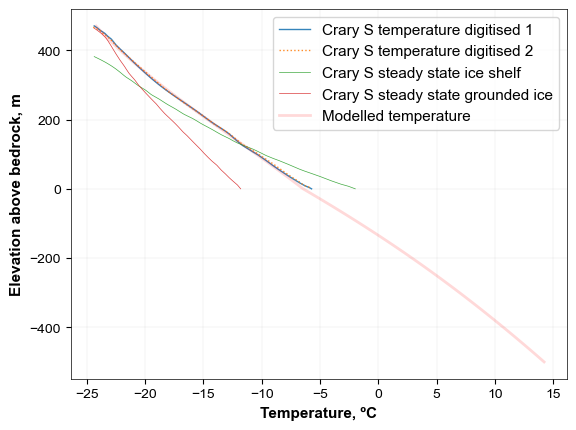

In [6]:
##### Implementing the forward model with some set of prior parameters

Tm_ungrounded_regrounded_var_360_470_int = Tmodel([360,470], 500, 10, 5e4, 2e4, 1e4, 9e2, [-24.2, -24.2], [0.11, 0.11], 950e-4)

##### Importing previously measured temperatures from Bindschadler et al 1991

Bindschadler_Crary_T_profile_D = np.genfromtxt('Binschadler_Crary_D_Temps.txt', delimiter='\t', skip_header=1)
Bindschadler_Crary_T_profile_S = np.genfromtxt('Binschadler_Crary_S_Temps.txt', delimiter='\t', skip_header=1)
Bindschadler_Crary_T_profile_x = np.genfromtxt('Bindschadler Crary Ice Rise digitized data.csv', delimiter=',', skip_header=1)


##### Plotting the results

plt.plot(Bindschadler_Crary_T_profile_x[:,0],Bindschadler_Crary_T_profile_x[:,1], linewidth=1, alpha=0.9,  label='Crary S temperature digitised 1')
plt.plot(Bindschadler_Crary_T_profile_D[:,0], Bindschadler_Crary_T_profile_D[:,1], ':', linewidth=1, alpha=0.9,  label='Crary S temperature digitised 2')
plt.plot(Bindschadler_Crary_T_profile_x[:,0],Bindschadler_Crary_T_profile_x[:,2],linewidth=0.5, alpha=0.9,  label='Crary S steady state ice shelf')
plt.plot(Bindschadler_Crary_T_profile_x[:,0],Bindschadler_Crary_T_profile_x[:,3],linewidth=0.5, alpha=0.9,  label='Crary S steady state grounded ice')
plt.plot(Tm_ungrounded_regrounded_var_360_470_int["Tvar_H_Tmatrix"][:,-1],Tm_ungrounded_regrounded_var_360_470_int["zvar_H_Tmatrix"][:,-1], 'r', linewidth=2, alpha=0.15, label='Modelled temperature')
plt.ylabel('Elevation above bedrock, m')
plt.xlabel('Temperature, ºC')
plt.grid()
plt.legend()


### Calculating RMS difference between modelled and calculated profiles

T_interp_Bind = rsmpl(Bindschadler_Crary_T_profile_x[:,0],Bindschadler_Crary_T_profile_x[:,1], 10)
T_interp_modelled = rsmpl(Tm_ungrounded_regrounded_var_360_470_int["Tvar_H_Tmatrix"][:,-1],Tm_ungrounded_regrounded_var_360_470_int["zvar_H_Tmatrix"][:,-1],10)
RMS(T_interp_modelled[0],T_interp_Bind[0])

#### 


***
## **2. Temperature profile MCMC inversion**

#### 

### 2.2 Running inversion with Crary Ice Rise temperature profile measurements (Bindschadler et al 1991) 

### Resetting the spatial grids

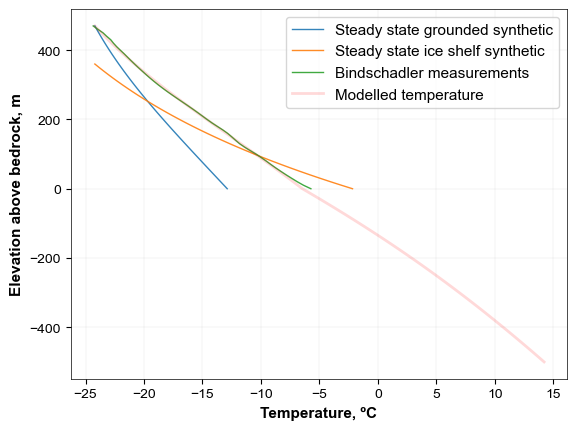

In [7]:
Hr = 500
Hend = 470
Hi = 470
dz = 10
z = np.linspace(-int(Hr), int(Hi), int((Hi+Hr)/dz) + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, int(Hi/dz) + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for ice

Tmeasured = T_interp_Bind[0]
Tsteady_grounded =  np.array(Tmodel([470,470], 500, 10, 15e3, 15e3, 0, 0, [-24.2, -24.2], [0.11, 0.11], 800e-4)["Tmeasured"])
Tsteady_ice_shelf =  np.array(Tmodel([360,360], 500, 10, 15e3, 15e3, 15e3, 0, [-24.2, -24.2], [0.11, 0.11], 800e-4)["Tmeasured"])

plt.plot(Tsteady_grounded[l-1:], z[l-1:],linewidth=1, alpha=0.9,  label='Steady state grounded synthetic')
plt.plot(Tsteady_ice_shelf[l-1:], z[l-1:-11],linewidth=1, alpha=0.9,  label='Steady state ice shelf synthetic')
plt.plot(Tmeasured, z[l-1:],linewidth=1, alpha=0.9,  label='Bindschadler measurements')
plt.plot(Tm_ungrounded_regrounded_var_360_470_int["Tvar_H_Tmatrix"][:,-1],Tm_ungrounded_regrounded_var_360_470_int["zvar_H_Tmatrix"][:,-1], 'r', linewidth=2, alpha=0.15, label='Modelled temperature')
plt.ylabel('Elevation above bedrock, m')
plt.xlabel('Temperature, ºC')
plt.grid()
plt.legend()

### Defining a new forward model function

In [8]:
def model_measured(theta, z):
    
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    a = a_yr/yr_to_s
    
    Hisim = [Hinitial, Hend]
    
    dHyr = (Hend-Hinitial)/t_grounding
    dH = dHyr/yr_to_s

    time_sim_Hi = np.linspace(1, int(t_grounding), num=len(Hisim))
    tmnew = np.linspace(1, int(t_grounding), int(t_grounding), endpoint=True)
    fthk = interp1d(time_sim_Hi, Hisim)
    thkhistory = fthk(tmnew)

    dzr = 10
    dz = dzr
    zi = np.linspace(0, int(Hinitial), int((Hinitial)/dz) + 1)   # Space calculation domain for ice and rock

    zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
    l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
    Lzi = len(zi) #  Number of elements in space domain for ice
    Lzr = len(zr) #  Number of elements in space domain for ice

    z = np.concatenate((zr[:-1],zi))
    Lz = len(z)

    Ts_surf_steady = T_sim
    Ts = -z*0 + Ts_surf_steady

    for i in range(0, int(15e3)):

        Hi = thkhistory[0]
        zi = np.linspace(0, int(Hi), Lzi)
        dz = int(Hi/Lzi)

        z = np.concatenate((zr[:-1],zi))

        # Ice shelf vertical velocity profile

        w = -np.linspace(a,a,Lzi) # Accumulation rate and basal melt/freeze rate are in balance

        # Above ice-rock interface

        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(w[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = Ts_surf_steady # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors

        Ts[l-1] = -1.89 - 7.53e-4*Hi


        # Below ice-rock interface

        Ts[1:l-1] = Ts[1:l-1] + dt*alpha_r*(Ts[2:l]-2*Ts[1:l-1]+Ts[0:l-2])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)

        # Recording the result into an empty matrix for comparison

    for j in range(0, int(t_grounding)):
        
        Hi = thkhistory[j]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi))          
            
        #  Interpolating previous temperature profile on to the new ice column space domain
        
        zint = np.linspace(0, thkhistory[j-1], Lzi)
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1)
        Ts[l-1:] = s(zi)
           
        # Grounded ice vertical velocity profile

        dws = a - dH # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = T_sim # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors
        
        # Temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
    Tx = rsmpl(Ts[l-1:], zi, 10)[0]
    
    return Tx

### Executing MCMC sampling

In [13]:
%%time

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model_measured(theta, x))/yerr) ** 2)


#def lnprior(theta):
#    Hinitial, t_grounding, G, a_yr, T_sim = theta
#    if 350 < Hinitial < 470 and 5 < t_grounding < 10000  and 0.06 < G < 0.11 and 0.05 < a_yr < 0.2 and -26 < T_sim < -22:
#        return 0.0
#    return -np.inf


#def lnprior(theta):
#    Hinitial, t_grounding, G, a_yr, T_sim = theta
#    if not 350 < Hinitial < 470 and 50 < t_grounding < 10000 and 0.05 < a_yr < 0.2 and -26 < T_sim < -22:
#        return -np.inf
#    mu=0.11
#    sigma=0.018
#    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2

def lnprior(theta):
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    if 350 < Hinitial < 470 and 5 < t_grounding < 10000 and 0.05 < a_yr < 0.2 and -26 < T_sim < -22:
        mu=0.11
        sigma=0.018
        return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2
    else:
        return -np.inf


def lnprob(theta,x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)



CPU times: user 21 µs, sys: 49 µs, total: 70 µs
Wall time: 81.1 µs


In [10]:
initial = [5.21241500e+02, -5.43296588e+01,  4.68211118e-02,  9.00583869e-02,
 -2.52017414e+01]

print(lnprior(initial))

-inf


In [23]:
%%time

Terr = 0.05*np.mean(Tmeasured)
data = (z,Tmeasured,Terr)
nwalkers = 20
niter = 1000
initial = np.array([400, 2000, 0.070, 0.15, -25])
ndim = len(initial) # Number of dimensions in the parameter space
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

from multiprocess import Pool

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 0, progress=True)
    sampler.reset()
    
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

with Pool() as pool:
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
 


print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

#tau = sampler.get_autocorr_time()
#print(tau)

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Hinitial", "t_grounding", "G", "a_yr", "T_sim"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

samples = sampler.flatchain
probabilities = sampler.flatlnprobability


import corner
fig = corner.corner(samples, labels=labels)



np.savetxt('samples_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), samples, delimiter=',')
np.savetxt('probabilities_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), probabilities, delimiter=',')

Running burn-in...


 22%|█████████                                 | 43/200 [08:14<30:07, 11.51s/it]


KeyboardInterrupt: 

### Preparing data for plotting and calculating RMS for a subset of samples

CPU times: user 51min 42s, sys: 56.4 s, total: 52min 39s
Wall time: 1h 3s


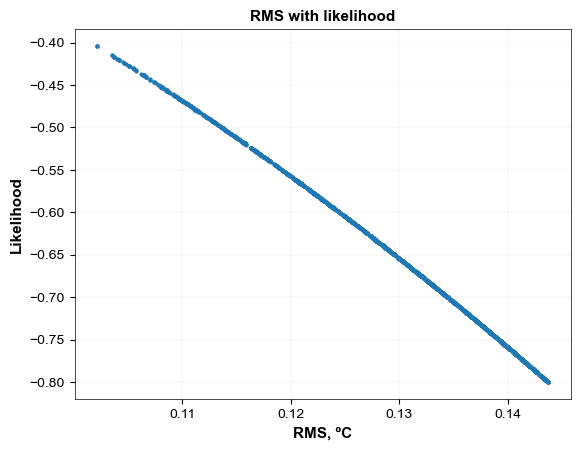

In [12]:
%%time

samples = np.loadtxt('samples_Crary_w_iceshelf_narrowed_[ 4.0e+02  2.0e+03  7.0e-02  1.5e-01 -2.5e+01]_varH_Temp_a_G__tgrounding_Crary_inversion_50_walkers_1000_iterations.csv', delimiter=',')
probabilities = np.loadtxt('probabilities_Crary_w_iceshelf_narrowed_[ 4.0e+02  2.0e+03  7.0e-02  1.5e-01 -2.5e+01]_varH_Temp_a_G__tgrounding_Crary_inversion_50_walkers_1000_iterations.csv', delimiter=',')

lnprobmax = -0.8
lnprobmin = -2.5

probmax = np.array(probabilities[(probabilities>lnprobmax)])

# Taking a sample

index = np.random.randint(len(samples[(probabilities>lnprobmax)]), size=2000)

# Retrieving inversion parameters from the MCMC sampler

hs1 = np.array(samples[(probabilities>lnprobmax)][:,0])[index]
xs1 = np.array(samples[(probabilities>lnprobmax)][:,1])[index]
ys1 = np.array(samples[(probabilities>lnprobmax)][:,2])[index]
zs1 = np.array(samples[(probabilities>lnprobmax)][:,3])[index]
ts1 = np.array(samples[(probabilities>lnprobmax)][:,4])[index]
hs = np.array(samples[(probabilities>lnprobmin)][:,0])
xs = np.array(samples[(probabilities>lnprobmin)][:,1])
ys = np.array(samples[(probabilities>lnprobmin)][:,2])
zs = np.array(samples[(probabilities>lnprobmin)][:,3])
ts = np.array(samples[(probabilities>lnprobmin)][:,4])


# Calculating RMS for best fit data


rmslik = [] 
for i in range (0,len(index)):
    rmslik.append(RMS(model_measured(samples[(probabilities>lnprobmax)][index[i]], z), Tmeasured))


# rmslik = [] 
# for i in range (0,len(probmax)):
#     rmslik.append(RMS(model_measured(samples[(probabilities>lnprobmax)][i], z), Tmeasured))
    
# np.savetxt('RMS_likelihood-random-1.0_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations_{parameters}.csv'.format(initial = initial, walkers=nwalkers, iterations = niter, parameters = initial), rmslik, delimiter=',')
    
plt.scatter(rmslik, probmax[index])
plt.xlabel('RMS, ºC')
plt.ylabel('Likelihood')
plt.title('RMS with likelihood')
plt.grid()

### Plotting the inversion results

<timed exec>:6: UserWarning: The figure layout has changed to tight
<timed exec>:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:53: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:100: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:113: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:126: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:160: UserWarning: No data for colormapping provided via 'c'

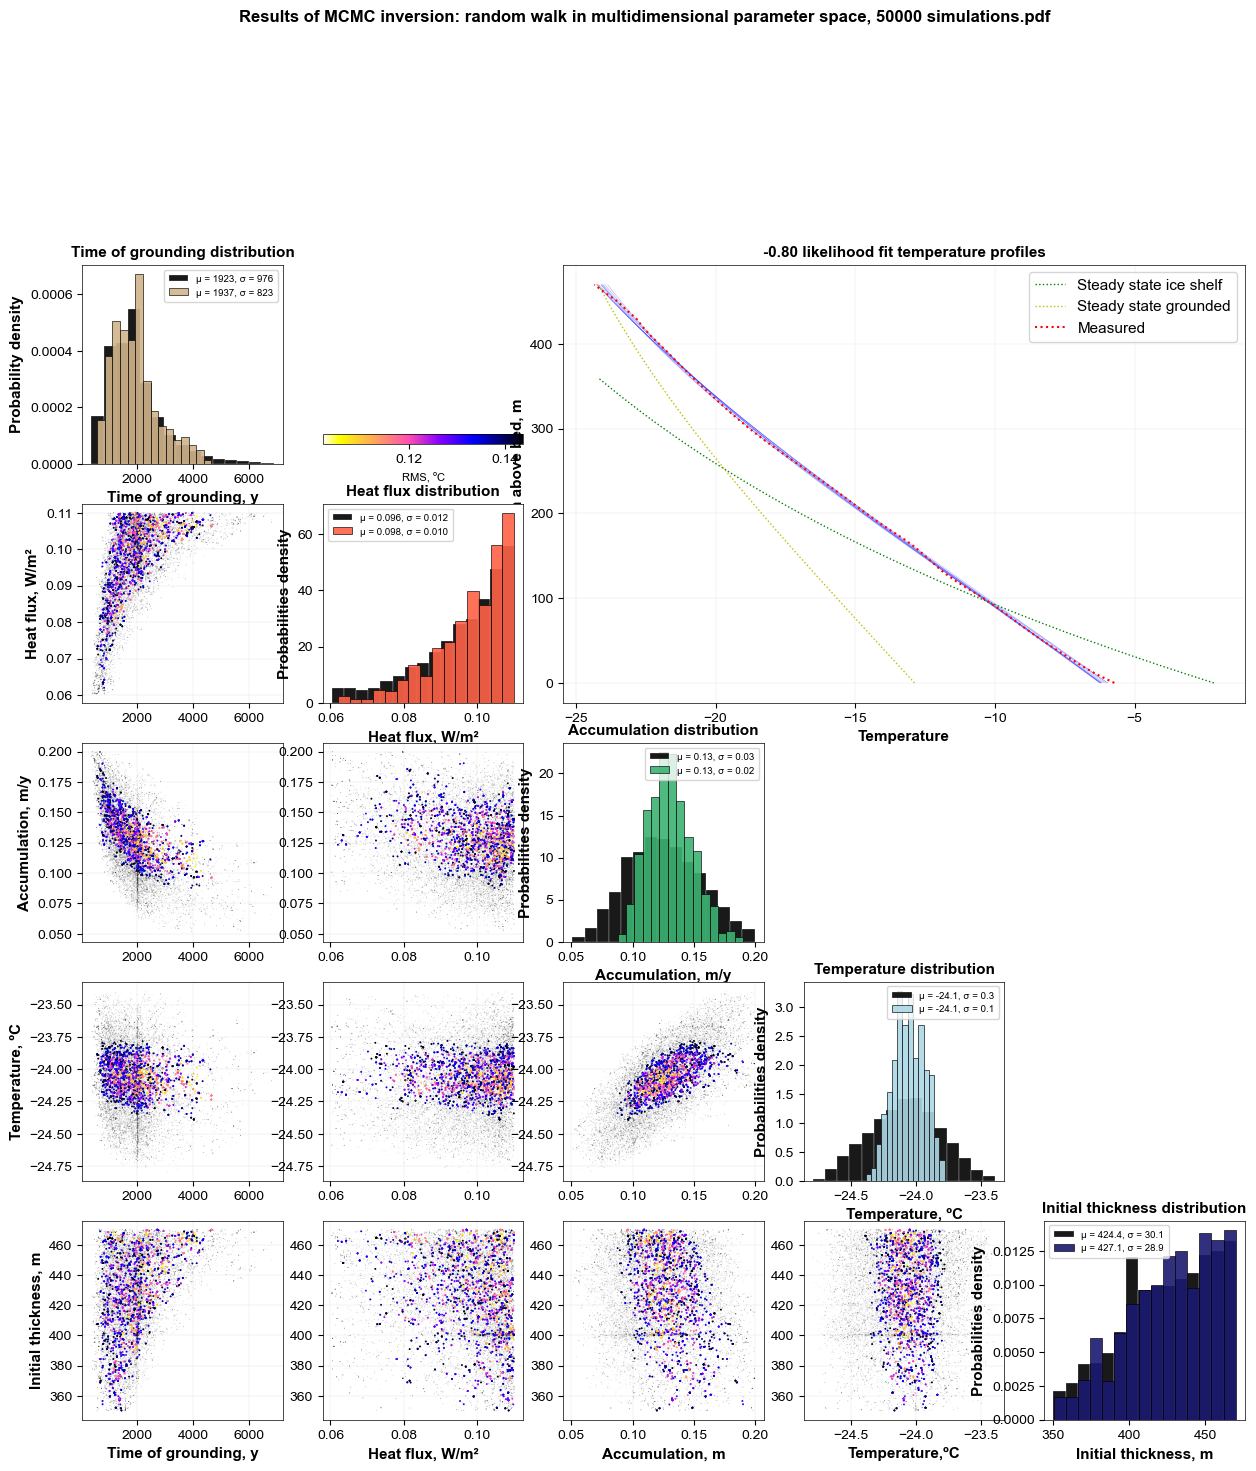

CPU times: user 19.3 s, sys: 520 ms, total: 19.8 s
Wall time: 19.5 s


In [14]:
%%time

# mpl.rcParams['figure.dpi'] = 200

fig = plt.figure(figsize=(15, 15), constrained_layout=True)

# fig, ax = plt.subplots(figsize=(15, 15), ncols=5, nrows = 5)
fig.tight_layout(pad=2.0)

fig.suptitle('Results of MCMC inversion: random walk in multidimensional parameter space, {:0.0f} simulations.pdf'.format(len(samples)), y=1.05)

gs = GridSpec(5, 5, figure=fig)


ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(xs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.0f}, \u03C3 = {:0.0f}".format(np.mean(xs),np.std(xs)))
ax1.hist(xs1, 15, density=True, facecolor='tan', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.0f}, \u03C3 = {:0.0f}".format(np.mean(xs1),np.std(xs1)))
ax1.set_xlabel('Time of grounding, y')
ax1.set_ylabel('Probability density')
ax1.set_title('Time of grounding distribution')
ax1.legend(borderpad=0.5,prop={'size':7})


ax2 = fig.add_subplot(gs[0:2, 2:5])
for theta in (samples[(probabilities>lnprobmax)])[np.random.randint(len(samples[(probabilities>lnprobmax)]), size=10)]:
    ax2.plot(model_measured(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=0.5)
# ax2.plot(model_measured(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=1, label = '{:0.2f} fit'.format(lnprobmax))
# for theta in (samples[(probabilities>lnprobmin)])[np.random.randint(len(samples[(probabilities>lnprobmin)]), size=10)]:
#     ax2.plot(model_measured(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=0.7)
ax2.plot(Tsteady_ice_shelf[l-1:], z[l-1:-11], 'g:', linewidth=1, label='Steady state ice shelf')
ax2.plot(Tsteady_grounded[l-1:], z[l-1:], 'y:', linewidth=1, label='Steady state grounded')
# ax2.plot(model_measured(theta, z), z[l-1:], 'k', linewidth=0.15, alpha=0.5, label = '{:0.2f} fit'.format(lnprobmin))
ax2.plot(Tmeasured, z[l-1:],'r:', linewidth=1.5,  label='Measured')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Elevation above bed, m')
ax2.grid(linestyle='-', linewidth=0.1)
ax2.legend()
ax2.set_title('{:0.2f} likelihood fit temperature profiles'.format(lnprobmax))


ax3 = fig.add_subplot(gs[1, 0])
pc0 = ax3.scatter(xs, ys,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax3.scatter(xs1, ys1,c= rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
# ax3.axhline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax3.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='y', alpha=0.05)
ax3.grid(linestyle='-', linewidth=0.1)
# ax3.set_xlabel('Time of grounding, y')
ax3.set_ylabel('Heat flux, W/m²')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m/y',weight = 'light',size = 8)
# ax3.legend()


ax4 = fig.add_subplot(gs[2, 0])
pc1 = ax4.scatter(xs, zs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc1 = ax4.scatter(xs1, zs1,c = rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
ax4.grid(linestyle='-', linewidth=0.1)
# ax4.axhline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax4.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[2,0].set_xlabel('Time of grounding, y')
ax4.set_ylabel('Accumulation, m/y')
# fig.colorbar(pc1, ax=ax[2,0]).set_label('Heat flux, W/m²',weight = 'light',size = 8)
# ax[2,0].legend()


ax5 = fig.add_subplot(gs[3, 0])
pc0 = ax5.scatter(xs, ts,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax5.scatter(xs1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
# ax5.axhline(-24, color='y', linestyle='-', linewidth=0.5)
# ax5.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='y', alpha=0.05)
ax5.grid(linestyle='-', linewidth=0.1)
# ax5.set_xlabel('Time of grounding, y')
ax5.set_ylabel('Temperature, ºC')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m/y',weight = 'light',size = 8)
# ax[3,0].legend()


ax6 = fig.add_subplot(gs[4, 0])
pc0 = ax6.scatter(xs, hs,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax6.scatter(xs1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
# ax6.axhline(-24, color='y', linestyle='-', linewidth=0.5)
# ax6.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='y', alpha=0.05)
ax6.grid(linestyle='-', linewidth=0.1)
ax6.set_xlabel('Time of grounding, y')
ax6.set_ylabel('Initial thickness, m')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m/y',weight = 'light',size = 8)
# ax[3,0].legend()


ax7 = fig.add_subplot(gs[1, 1])
ax7.hist(ys, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.3f}, \u03C3 = {:0.3f}".format(np.mean(ys),np.std(ys)))
ax7.hist(ys1, 15, density=True, facecolor='tomato', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.3f}, \u03C3 = {:0.3f}".format(np.mean(ys1),np.std(ys1)))
ax7.set_xlabel('Heat flux, W/m²')
ax7.set_ylabel('Probabilities density')
ax7.set_title('Heat flux distribution')
ax7.legend(borderpad=0.5,prop={'size':7})


ax8 = fig.add_subplot(gs[2, 1])
pc2 = ax8.scatter(ys, zs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc2 = ax8.scatter(ys1, zs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax8.axvline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax8.axhline(0.11, color='y', linestyle='-', linewidth=0.5)
ax8.grid(linestyle='-', linewidth=0.1)
# ax[2,1].set_xlabel('Heat flux, W/m²')
# ax[2,1].set_ylabel('Accumulation, m/y')
# fig.colorbar(pc2, ax=ax[2,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[2,1].legend()


ax9 = fig.add_subplot(gs[3, 1])
pc3 = ax9.scatter(ys, ts, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax9.scatter(ys1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax9.axvline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax9.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax9.grid(linestyle='-', linewidth=0.1)
# ax9.set_xlabel('Heat flux, W/m²')
# ax[3,1].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,1].legend()


ax10 = fig.add_subplot(gs[4, 1])
pc3 = ax10.scatter(ys, hs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax10.scatter(ys1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax10.axvline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax10.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax10.grid(linestyle='-', linewidth=0.1)
ax10.set_xlabel('Heat flux, W/m²')
# ax[3,1].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,1].legend()


ax11 = fig.add_subplot(gs[2, 2])
ax11.hist(zs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.2f}, \u03C3 = {:0.2f}".format(np.mean(zs),np.std(zs)))
ax11.hist(zs1, 15, density=True, facecolor='mediumseagreen', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.2f}, \u03C3 = {:0.2f}".format(np.mean(zs1),np.std(zs1)))
ax11.set_xlabel('Accumulation, m/y')
ax11.set_ylabel('Probabilities density')
ax11.set_title('Accumulation distribution')
ax11.legend(borderpad=0.5,prop={'size':7})


ax12 = fig.add_subplot(gs[3, 2])
pc3 = ax12.scatter(zs, ts, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax12.scatter(zs1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax12.axvline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax12.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax12.grid(linestyle='-', linewidth=0.1)
# ax12.set_xlabel('Accumulation, m/y')
# ax[3,2].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,2].legend()

ax13 = fig.add_subplot(gs[4, 2])
pc3 = ax13.scatter(zs, hs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax13.scatter(zs1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax13.axvline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax13.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax13.grid(linestyle='-', linewidth=0.1)
ax13.set_xlabel('Accumulation, m')
# ax[3,2].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,2].legend()


ax14 = fig.add_subplot(gs[3, 3])
ax14.hist(ts, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(ts),np.std(ts)))
ax14.hist(ts1, 15, density=True, facecolor='lightblue', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(ts1),np.std(ts1)))
ax14.set_xlabel('Temperature, ºC')
ax14.set_ylabel('Probabilities density')
ax14.set_title('Temperature distribution')
ax14.legend(borderpad=0.5,prop={'size':7})


ax15 = fig.add_subplot(gs[4, 3])
pc3 = ax15.scatter(ts, hs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax15.scatter(ts1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax15.axvline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax15.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax15.grid(linestyle='-', linewidth=0.1)
ax15.set_xlabel('Temperature,ºC')
# ax[3,2].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,2].legend()

ax16 = fig.add_subplot(gs[4, 4])
ax16.hist(hs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(hs),np.std(hs)))
ax16.hist(hs1, 15, density=True, facecolor='midnightblue', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(hs1),np.std(hs1)))
ax16.set_xlabel('Initial thickness, m')
ax16.set_ylabel('Probabilities density')
ax16.set_title('Initial thickness distribution')
ax16.legend(borderpad=0.5,prop={'size':7})

ax17 = fig.add_subplot(gs[0, 1])
fig.colorbar(pc3, ax=ax17, orientation="horizontal", pad=-0.2).set_label('RMS, ºC',weight = 'light',size = 8)
ax17.xaxis.set_visible(False)
ax17.yaxis.set_visible(False)
ax17.axis("off")
plt.show()

# fig.suptitle("GridSpec")
# format_axes(f

plt.show()

# fig.savefig('Crary_inversion_time_variable_temp_profile_w_ice_shelf{:0.0f}_simulations.pdf'.format(len(samples)))

## 2.3 Running inversion with Skytrain Ice Rise temperature profile measurements

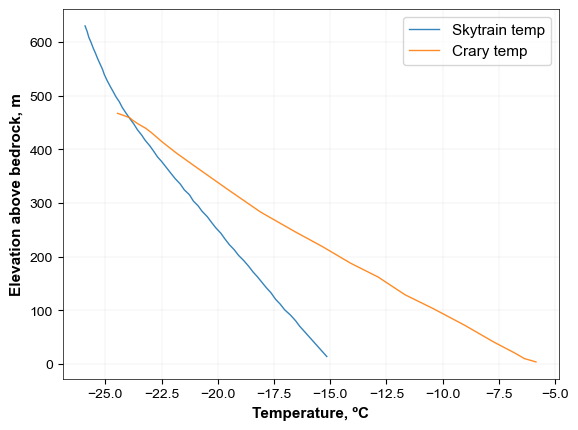

In [15]:
Bindschadler_Crary_T_profile_D = np.genfromtxt('Binschadler_Crary_D_Temps.txt', delimiter='\t', skip_header=1)
Skytrain_T_profile = np.genfromtxt('skytrain_temp_profile.csv', delimiter=',', skip_header=1)



##### Plotting the results

plt.plot(Skytrain_T_profile[:,0],Skytrain_T_profile[:,1], linewidth=1, alpha=0.9,  label='Skytrain temp')
plt.plot(Bindschadler_Crary_T_profile_D[:,0], Bindschadler_Crary_T_profile_D[:,1], linewidth=1, alpha=0.9,  label='Crary temp')
#plt.plot(Tm_ungrounded_regrounded_var_360_470_int["Tvar_H_Tmatrix"][:,-1],Tm_ungrounded_regrounded_var_360_470_int["zvar_H_Tmatrix"][:,-1], 'r', linewidth=2, alpha=0.15, label='Modelled temperature')
plt.ylabel('Elevation above bedrock, m')
plt.xlabel('Temperature, ºC')
plt.grid()
plt.legend()

In [16]:
def rsmpl_2(T_in, z_in, dz):
    flinear = interp1d(z_in, T_in, fill_value='extrapolate')
    
    z_out = np.arange(round(min(z_in), -1)-10, int(max(z_in))+10, dz)
    T_out = flinear(z_out)
    
    return [T_out, z_out]

In [17]:
T_interp_skytrain = rsmpl_2(Skytrain_T_profile[:,0],Skytrain_T_profile[:,1], 10)
print(T_interp_skytrain)

Tmeasured = T_interp_skytrain[0]
z = T_interp_skytrain[1]
#print(Tmeasured)

[array([-14.85792921, -15.07125243, -15.28457566, -15.49789888,
       -15.71122211, -15.92454533, -16.13786856, -16.35366865,
       -16.53156579, -16.74451084, -17.00218635, -17.1978851 ,
       -17.42054884, -17.5913616 , -17.79725823, -17.99699211,
       -18.1916255 , -18.40207422, -18.59095453, -18.79272806,
       -19.02211533, -19.21851659, -19.43567366, -19.6292223 ,
       -19.80413219, -20.00805492, -20.20832808, -20.38958476,
       -20.59719005, -20.79599029, -21.00398186, -21.18306919,
       -21.38050795, -21.58281388, -21.77737387, -21.9861009 ,
       -22.17553316, -22.36273386, -22.55850437, -22.74980876,
       -22.91477454, -23.0965092 , -23.28315968, -23.45428983,
       -23.62906595, -23.78634454, -23.95904944, -24.12440237,
       -24.27421372, -24.40360649, -24.55722078, -24.68780448,
       -24.81932479, -24.94316221, -25.05229586, -25.13787612,
       -25.24729695, -25.35304198, -25.45009861, -25.55313089,
       -25.64557245, -25.74421699, -25.81383326, -25.9

### Resetting the spatial grids

In [18]:
Hr = 500
Hend = 630
Hi = 630
dz = 10
z = np.linspace(-int(Hr), int(Hi), int((Hi+Hr)/dz) + 1)   # Space calculation domain for ice and rock
zi = np.linspace(0, Hi, int(Hi/dz) + 1)  # Space calculation domain for ice
zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
Lz = len(z)  # Number of elements in space domain
Lzi = len(zi) #  Number of elements in space domain for ice
Lzr = len(zr) #  Number of elements in space domain for ice


### Defining a new forward model function

In [19]:
def model_measured(theta, z):
    
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    a = a_yr/yr_to_s
    
    Hisim = [Hinitial, Hend]
    
    dHyr = (Hend-Hinitial)/t_grounding
    dH = dHyr/yr_to_s

    time_sim_Hi = np.linspace(1, int(t_grounding), num=len(Hisim))
    tmnew = np.linspace(1, int(t_grounding), int(t_grounding), endpoint=True)
    fthk = interp1d(time_sim_Hi, Hisim)
    thkhistory = fthk(tmnew)

    dzr = 10
    dz = dzr
    zi = np.linspace(0, int(Hinitial), int((Hinitial)/dz) + 1)   # Space calculation domain for ice and rock

    zr = np.linspace(-Hr, 0, int(Hr/dz) + 1) #  Space calculation domain for rock
    l = len(zr)  # Index for ice-bed interface to be used in the loop calculations
    Lzi = len(zi) #  Number of elements in space domain for ice
    Lzr = len(zr) #  Number of elements in space domain for ice

    z = np.concatenate((zr[:-1],zi))
    Lz = len(z)

    Ts_surf_steady = T_sim
    Ts = -z*0 + Ts_surf_steady

    for i in range(0, int(15e3)):

        Hi = thkhistory[0]
        zi = np.linspace(0, int(Hi), Lzi)
        dz = int(Hi/Lzi)

        z = np.concatenate((zr[:-1],zi))

        # Ice shelf vertical velocity profile

        w = -np.linspace(a,a,Lzi) # Accumulation rate and basal melt/freeze rate are in balance

        # Above ice-rock interface

        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(w[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = Ts_surf_steady # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors

        Ts[l-1] = -1.89 - 7.53e-4*Hi


        # Below ice-rock interface

        Ts[1:l-1] = Ts[1:l-1] + dt*alpha_r*(Ts[2:l]-2*Ts[1:l-1]+Ts[0:l-2])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)

        # Recording the result into an empty matrix for comparison

    for j in range(0, int(t_grounding)):
        
        Hi = thkhistory[j]
        zi = np.linspace(0, Hi, Lzi)
        dz = Hi/Lzi
        z = np.concatenate((zr[:-1],zi))          
            
        #  Interpolating previous temperature profile on to the new ice column space domain
        
        zint = np.linspace(0, thkhistory[j-1], Lzi)
        s = InterpolatedUnivariateSpline(zint, Ts[l-1:], k=1)
        Ts[l-1:] = s(zi)
           
        # Grounded ice vertical velocity profile

        dws = a - dH # When thickness is variable through time
        wzt = (1 - (((n + 2) / (n + 1)) * (1 - zi / Hi)) + (1 / (n + 1)) * np.power((1 - zi / Hi), (n + 2)))
        ws = -dws * wzt

        # Temperature calculation above ice-rock interface
        
        Ts[l:-1] = Ts[l:-1] + dt*(alpha_i*(Ts[l+1:]-2*Ts[l:-1]+Ts[l-1:-2])/dz**2 - np.multiply(ws[1:-1],(Ts[l+1:]-Ts[l-1:-2])/(2*dz)))
        Ts[-1] = T_sim # Temperature forcing is constant and equals the first value of the imported Monte-Carlo surface temperature vectors
        
        # Temperature calculation below ice-rock interface
    
        Ts[1:l] = Ts[1:l] + dt * alpha_r * (Ts[2:l+1]-2*Ts[1:l]+Ts[0:l-1])/dzr**2
        Ts[0] = Ts[1] + (G/k_r*dzr)
        
    Tx = rsmpl(Ts[l-1:], zi, 10)[0]
    
    return Tx

### Executing MCMC sampling

In [68]:
%%time

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model_measured(theta, x))/yerr) ** 2)


#def lnprior(theta):
#    Hinitial, t_grounding, G, a_yr, T_sim = theta
#    if 350 < Hinitial < 470 and 5 < t_grounding < 10000  and 0.06 < G < 0.11 and 0.05 < a_yr < 0.2 and -26 < T_sim < -22:
#        return 0.0
#    return -np.inf


#def lnprior(theta):
#    Hinitial, t_grounding, G, a_yr, T_sim = theta
 #   if not 350 < Hinitial < 470 and 5 < t_grounding < 10000 and 0.05 < a_yr < 0.2 and -26 < T_sim < -22:
  #      return -np.inf
   # mu=0.11
    #sigma=0.018
    #return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2

#def lnprior(theta):
#    Hinitial, t_grounding, G, a_yr, T_sim = theta
#    if 350 < Hinitial < 630 and 5 < t_grounding < 10000 and 0.05 < a_yr < 0.2 and -26 < T_sim < -22:
#        mu=0.102
#        sigma=0.018
#        return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2
#    else:
#        return -np.inf

    
def lnprior(theta):
    Hinitial, t_grounding, G, a_yr, T_sim = theta
    if 350 < Hinitial < 630 and 5 < t_grounding < 15000 and 0.01 < a_yr < 0.3 and -28 < T_sim < -23:
        mu=0.102
        sigma=0.018
        Gi = np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(G-mu)**2/sigma**2
        if Gi < 0:
            return 0
        else:
            return Gi
    else:
        return -np.inf
    

def lnprob(theta,x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


CPU times: user 54 µs, sys: 189 µs, total: 243 µs
Wall time: 2.2 ms


In [69]:
theta = [550, 5000, 0.07, 0.1, -26]
test = lnprior(theta)
print(test)

1.518198074301054


Running burn-in...


100%|███████████████████████████████████████████| 10/10 [02:08<00:00, 12.84s/it]


Running production...


100%|███████████████████████████████████████| 600/600 [1:42:16<00:00, 10.23s/it]


Mean acceptance fraction: 0.458


CPU times: user 11.8 s, sys: 1.94 s, total: 13.7 s
Wall time: 1h 44min 51s


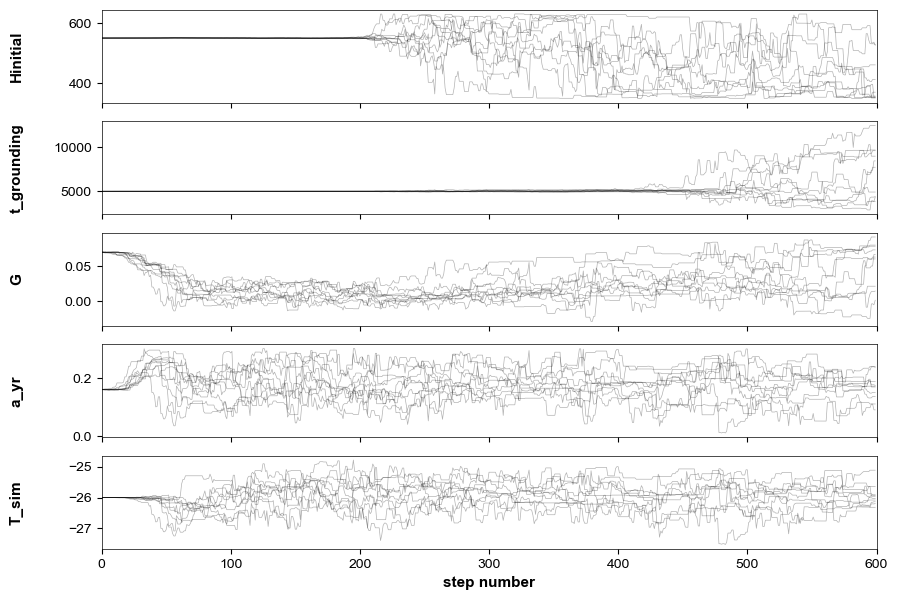

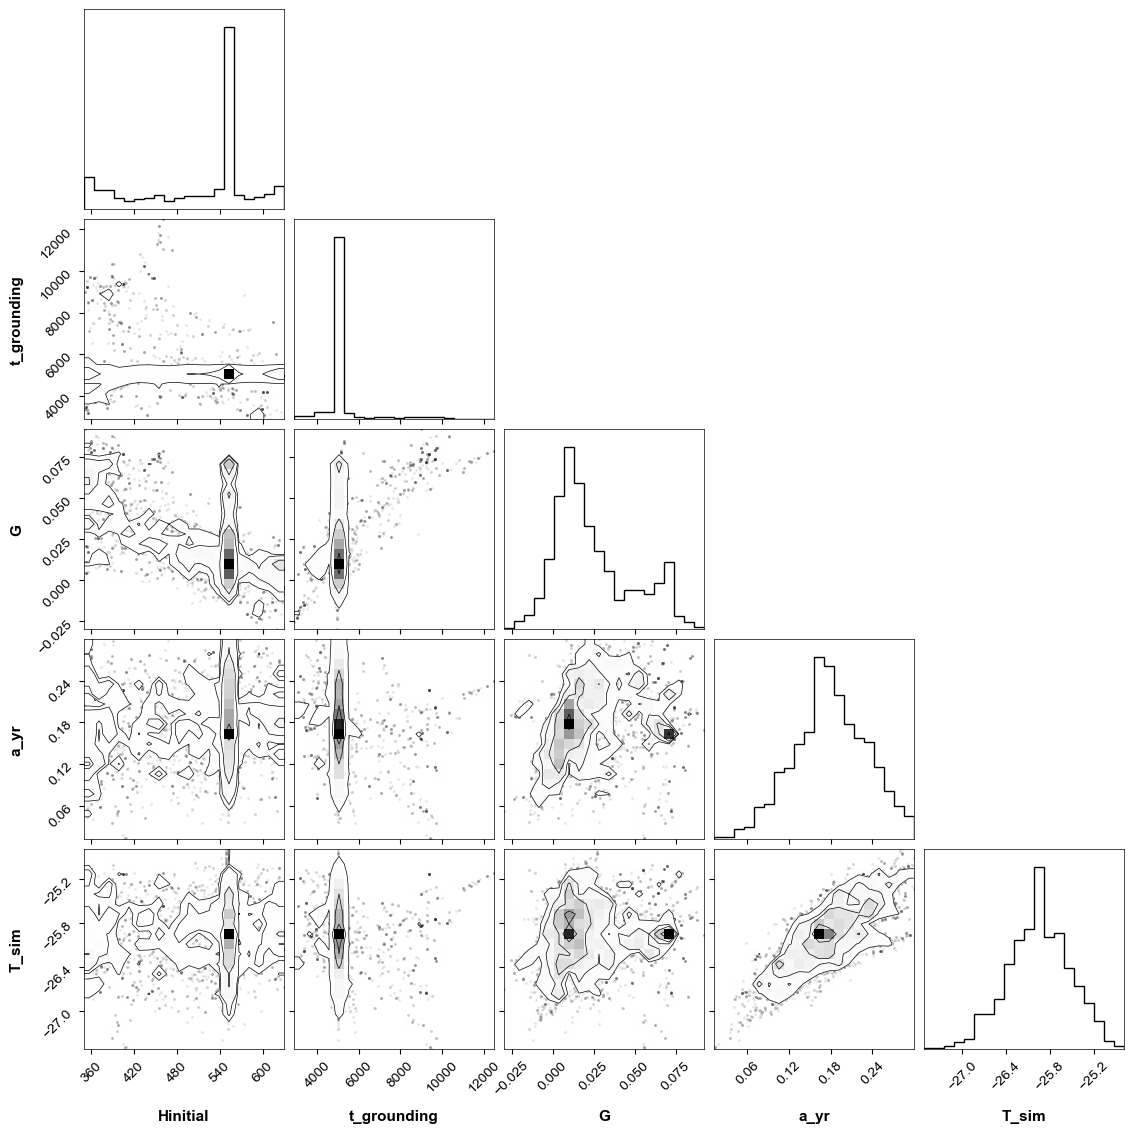

In [70]:
%%time

Terr = 0.05*np.mean(Tmeasured)
data = (z,Tmeasured,Terr)
nwalkers = 10
niter = 600
initial = np.array([550, 5000, 0.070, 0.16, -26])
ndim = len(initial) # Number of dimensions in the parameter space
p0 = [np.array(initial) + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

from multiprocess import Pool

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data, pool=pool)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 10, progress=True)
    sampler.reset()
    
    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

with Pool() as pool:
    sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)
 


print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

#tau = sampler.get_autocorr_time()
#print(tau)

fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Hinitial", "t_grounding", "G", "a_yr", "T_sim"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

samples = sampler.flatchain
probabilities = sampler.flatlnprobability


import corner
fig = corner.corner(samples, labels=labels)



np.savetxt('samples_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), samples, delimiter=',')
np.savetxt('probabilities_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations.csv'.format(initial = initial, walkers=nwalkers, iterations = niter), probabilities, delimiter=',')

### Preparing data for plotting and calculating RMS for a subset of samples

CPU times: user 52min, sys: 45.9 s, total: 52min 46s
Wall time: 55min 14s


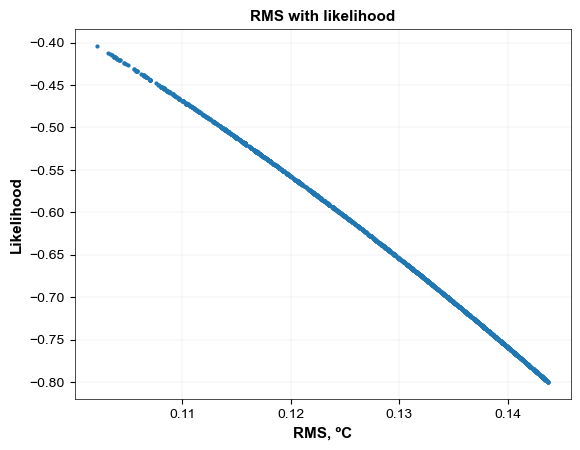

In [61]:
%%time

samples = np.loadtxt('samples_Crary_w_iceshelf_narrowed_[ 4.0e+02  2.0e+03  7.0e-02  1.5e-01 -2.5e+01]_varH_Temp_a_G__tgrounding_Crary_inversion_50_walkers_1000_iterations.csv', delimiter=',')
probabilities = np.loadtxt('probabilities_Crary_w_iceshelf_narrowed_[ 4.0e+02  2.0e+03  7.0e-02  1.5e-01 -2.5e+01]_varH_Temp_a_G__tgrounding_Crary_inversion_50_walkers_1000_iterations.csv', delimiter=',')

lnprobmax = -0.8
lnprobmin = -2.5

probmax = np.array(probabilities[(probabilities>lnprobmax)])

# Taking a sample

index = np.random.randint(len(samples[(probabilities>lnprobmax)]), size=2000)

# Retrieving inversion parameters from the MCMC sampler

hs1 = np.array(samples[(probabilities>lnprobmax)][:,0])[index]
xs1 = np.array(samples[(probabilities>lnprobmax)][:,1])[index]
ys1 = np.array(samples[(probabilities>lnprobmax)][:,2])[index]
zs1 = np.array(samples[(probabilities>lnprobmax)][:,3])[index]
ts1 = np.array(samples[(probabilities>lnprobmax)][:,4])[index]
hs = np.array(samples[(probabilities>lnprobmin)][:,0])
xs = np.array(samples[(probabilities>lnprobmin)][:,1])
ys = np.array(samples[(probabilities>lnprobmin)][:,2])
zs = np.array(samples[(probabilities>lnprobmin)][:,3])
ts = np.array(samples[(probabilities>lnprobmin)][:,4])


# Calculating RMS for best fit data


rmslik = [] 
for i in range (0,len(index)):
    rmslik.append(RMS(model_measured(samples[(probabilities>lnprobmax)][index[i]], z), Tmeasured))


# rmslik = [] 
# for i in range (0,len(probmax)):
#     rmslik.append(RMS(model_measured(samples[(probabilities>lnprobmax)][i], z), Tmeasured))
    
# np.savetxt('RMS_likelihood-random-1.0_Crary_w_iceshelf_narrowed_{initial}_varH_Temp_a_G__tgrounding_Crary_inversion_{walkers}_walkers_{iterations}_iterations_{parameters}.csv'.format(initial = initial, walkers=nwalkers, iterations = niter, parameters = initial), rmslik, delimiter=',')
    
plt.scatter(rmslik, probmax[index])
plt.xlabel('RMS, ºC')
plt.ylabel('Likelihood')
plt.title('RMS with likelihood')
plt.grid()

### Plotting the inversion results

<timed exec>:6: UserWarning: The figure layout has changed to tight
<timed exec>:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:53: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:100: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:113: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:126: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
<timed exec>:160: UserWarning: No data for colormapping provided via 'c'

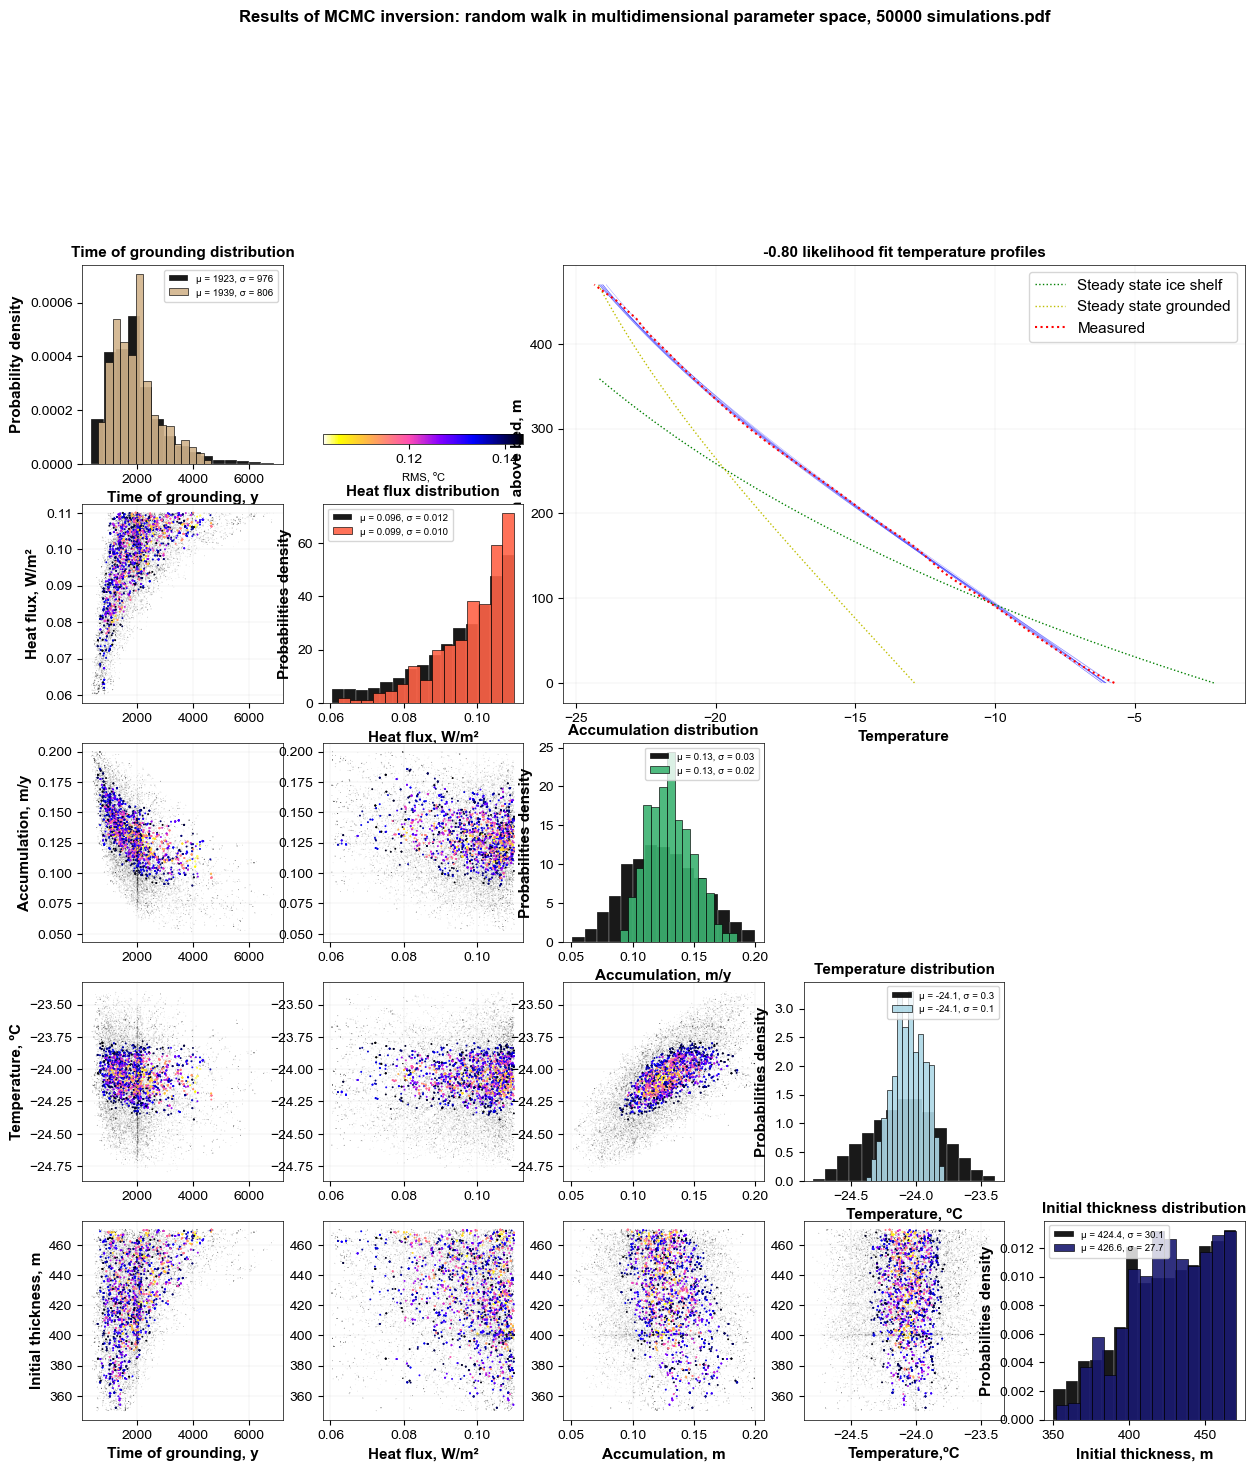

CPU times: user 21.1 s, sys: 496 ms, total: 21.6 s
Wall time: 21.9 s


In [62]:
%%time

# mpl.rcParams['figure.dpi'] = 200

fig = plt.figure(figsize=(15, 15), constrained_layout=True)

# fig, ax = plt.subplots(figsize=(15, 15), ncols=5, nrows = 5)
fig.tight_layout(pad=2.0)

fig.suptitle('Results of MCMC inversion: random walk in multidimensional parameter space, {:0.0f} simulations.pdf'.format(len(samples)), y=1.05)

gs = GridSpec(5, 5, figure=fig)


ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(xs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.0f}, \u03C3 = {:0.0f}".format(np.mean(xs),np.std(xs)))
ax1.hist(xs1, 15, density=True, facecolor='tan', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.0f}, \u03C3 = {:0.0f}".format(np.mean(xs1),np.std(xs1)))
ax1.set_xlabel('Time of grounding, y')
ax1.set_ylabel('Probability density')
ax1.set_title('Time of grounding distribution')
ax1.legend(borderpad=0.5,prop={'size':7})


ax2 = fig.add_subplot(gs[0:2, 2:5])
for theta in (samples[(probabilities>lnprobmax)])[np.random.randint(len(samples[(probabilities>lnprobmax)]), size=10)]:
    ax2.plot(model_measured(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=0.5)
# ax2.plot(model_measured(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=1, label = '{:0.2f} fit'.format(lnprobmax))
# for theta in (samples[(probabilities>lnprobmin)])[np.random.randint(len(samples[(probabilities>lnprobmin)]), size=10)]:
#     ax2.plot(model_measured(theta, z), z[l-1:], 'b', linewidth=0.25, alpha=0.7)
ax2.plot(Tsteady_ice_shelf[l-1:], z[l-1:-11], 'g:', linewidth=1, label='Steady state ice shelf')
ax2.plot(Tsteady_grounded[l-1:], z[l-1:], 'y:', linewidth=1, label='Steady state grounded')
# ax2.plot(model_measured(theta, z), z[l-1:], 'k', linewidth=0.15, alpha=0.5, label = '{:0.2f} fit'.format(lnprobmin))
ax2.plot(Tmeasured, z[l-1:],'r:', linewidth=1.5,  label='Measured')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Elevation above bed, m')
ax2.grid(linestyle='-', linewidth=0.1)
ax2.legend()
ax2.set_title('{:0.2f} likelihood fit temperature profiles'.format(lnprobmax))


ax3 = fig.add_subplot(gs[1, 0])
pc0 = ax3.scatter(xs, ys,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax3.scatter(xs1, ys1,c= rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
# ax3.axhline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax3.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='y', alpha=0.05)
ax3.grid(linestyle='-', linewidth=0.1)
# ax3.set_xlabel('Time of grounding, y')
ax3.set_ylabel('Heat flux, W/m²')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m/y',weight = 'light',size = 8)
# ax3.legend()


ax4 = fig.add_subplot(gs[2, 0])
pc1 = ax4.scatter(xs, zs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc1 = ax4.scatter(xs1, zs1,c = rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
ax4.grid(linestyle='-', linewidth=0.1)
# ax4.axhline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax4.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[2,0].set_xlabel('Time of grounding, y')
ax4.set_ylabel('Accumulation, m/y')
# fig.colorbar(pc1, ax=ax[2,0]).set_label('Heat flux, W/m²',weight = 'light',size = 8)
# ax[2,0].legend()


ax5 = fig.add_subplot(gs[3, 0])
pc0 = ax5.scatter(xs, ts,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax5.scatter(xs1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
# ax5.axhline(-24, color='y', linestyle='-', linewidth=0.5)
# ax5.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='y', alpha=0.05)
ax5.grid(linestyle='-', linewidth=0.1)
# ax5.set_xlabel('Time of grounding, y')
ax5.set_ylabel('Temperature, ºC')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m/y',weight = 'light',size = 8)
# ax[3,0].legend()


ax6 = fig.add_subplot(gs[4, 0])
pc0 = ax6.scatter(xs, hs,c= 'k', s = 0.5, alpha=0.05,edgecolors='none', cmap='gnuplot2_r')
pc0 = ax6.scatter(xs1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none', cmap='gnuplot2_r')
# ax6.axhline(-24, color='y', linestyle='-', linewidth=0.5)
# ax6.axvline(1100, color='y', linestyle='-', linewidth=0.5)
# ax[0].axhspan(0.040, 0.060, facecolor='y', alpha=0.05)
ax6.grid(linestyle='-', linewidth=0.1)
ax6.set_xlabel('Time of grounding, y')
ax6.set_ylabel('Initial thickness, m')
# fig.colorbar(pc0, ax=ax[2,0]).set_label('Accumulation, m/y',weight = 'light',size = 8)
# ax[3,0].legend()


ax7 = fig.add_subplot(gs[1, 1])
ax7.hist(ys, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.3f}, \u03C3 = {:0.3f}".format(np.mean(ys),np.std(ys)))
ax7.hist(ys1, 15, density=True, facecolor='tomato', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.3f}, \u03C3 = {:0.3f}".format(np.mean(ys1),np.std(ys1)))
ax7.set_xlabel('Heat flux, W/m²')
ax7.set_ylabel('Probabilities density')
ax7.set_title('Heat flux distribution')
ax7.legend(borderpad=0.5,prop={'size':7})


ax8 = fig.add_subplot(gs[2, 1])
pc2 = ax8.scatter(ys, zs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc2 = ax8.scatter(ys1, zs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax8.axvline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax8.axhline(0.11, color='y', linestyle='-', linewidth=0.5)
ax8.grid(linestyle='-', linewidth=0.1)
# ax[2,1].set_xlabel('Heat flux, W/m²')
# ax[2,1].set_ylabel('Accumulation, m/y')
# fig.colorbar(pc2, ax=ax[2,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[2,1].legend()


ax9 = fig.add_subplot(gs[3, 1])
pc3 = ax9.scatter(ys, ts, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax9.scatter(ys1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax9.axvline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax9.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax9.grid(linestyle='-', linewidth=0.1)
# ax9.set_xlabel('Heat flux, W/m²')
# ax[3,1].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,1].legend()


ax10 = fig.add_subplot(gs[4, 1])
pc3 = ax10.scatter(ys, hs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax10.scatter(ys1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax10.axvline(0.077, color='y', linestyle='-', linewidth=0.5)
# ax10.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax10.grid(linestyle='-', linewidth=0.1)
ax10.set_xlabel('Heat flux, W/m²')
# ax[3,1].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,1].legend()


ax11 = fig.add_subplot(gs[2, 2])
ax11.hist(zs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.2f}, \u03C3 = {:0.2f}".format(np.mean(zs),np.std(zs)))
ax11.hist(zs1, 15, density=True, facecolor='mediumseagreen', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.2f}, \u03C3 = {:0.2f}".format(np.mean(zs1),np.std(zs1)))
ax11.set_xlabel('Accumulation, m/y')
ax11.set_ylabel('Probabilities density')
ax11.set_title('Accumulation distribution')
ax11.legend(borderpad=0.5,prop={'size':7})


ax12 = fig.add_subplot(gs[3, 2])
pc3 = ax12.scatter(zs, ts, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax12.scatter(zs1, ts1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax12.axvline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax12.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax12.grid(linestyle='-', linewidth=0.1)
# ax12.set_xlabel('Accumulation, m/y')
# ax[3,2].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,2].legend()

ax13 = fig.add_subplot(gs[4, 2])
pc3 = ax13.scatter(zs, hs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax13.scatter(zs1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax13.axvline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax13.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax13.grid(linestyle='-', linewidth=0.1)
ax13.set_xlabel('Accumulation, m')
# ax[3,2].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,2].legend()


ax14 = fig.add_subplot(gs[3, 3])
ax14.hist(ts, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(ts),np.std(ts)))
ax14.hist(ts1, 15, density=True, facecolor='lightblue', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(ts1),np.std(ts1)))
ax14.set_xlabel('Temperature, ºC')
ax14.set_ylabel('Probabilities density')
ax14.set_title('Temperature distribution')
ax14.legend(borderpad=0.5,prop={'size':7})


ax15 = fig.add_subplot(gs[4, 3])
pc3 = ax15.scatter(ts, hs, c = 'k', s = 0.5, alpha=0.05, edgecolors='none',cmap='gnuplot2_r')
pc3 = ax15.scatter(ts1, hs1,c= rmslik, s = 2, alpha=1,edgecolors='none',cmap='gnuplot2_r')
# ax[2].axvspan(0.040, 0.060, facecolor='y', alpha=0.05)
# ax15.axvline(0.11, color='y', linestyle='-', linewidth=0.5)
# ax15.axhline(-24, color='y', linestyle='-', linewidth=0.5)
ax15.grid(linestyle='-', linewidth=0.1)
ax15.set_xlabel('Temperature,ºC')
# ax[3,2].set_ylabel('Temperature, ºC')
# fig.colorbar(pc2, ax=ax[3,1]).set_label('Grounding, years ago',weight = 'light',size = 8)
# ax[3,2].legend()

ax16 = fig.add_subplot(gs[4, 4])
ax16.hist(hs, 15, density=True, facecolor='black', edgecolor='white', alpha=0.9, linewidth=0.2, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(hs),np.std(hs)))
ax16.hist(hs1, 15, density=True, facecolor='midnightblue', edgecolor='black', alpha=0.9, linewidth=0.5, label = "\u03bc = {:0.1f}, \u03C3 = {:0.1f}".format(np.mean(hs1),np.std(hs1)))
ax16.set_xlabel('Initial thickness, m')
ax16.set_ylabel('Probabilities density')
ax16.set_title('Initial thickness distribution')
ax16.legend(borderpad=0.5,prop={'size':7})

ax17 = fig.add_subplot(gs[0, 1])
fig.colorbar(pc3, ax=ax17, orientation="horizontal", pad=-0.2).set_label('RMS, ºC',weight = 'light',size = 8)
ax17.xaxis.set_visible(False)
ax17.yaxis.set_visible(False)
ax17.axis("off")
plt.show()

# fig.suptitle("GridSpec")
# format_axes(f

plt.show()

# fig.savefig('Crary_inversion_time_variable_temp_profile_w_ice_shelf{:0.0f}_simulations.pdf'.format(len(samples)))

Plotting temperature profiles of Crary and Skytrain Ice Rises

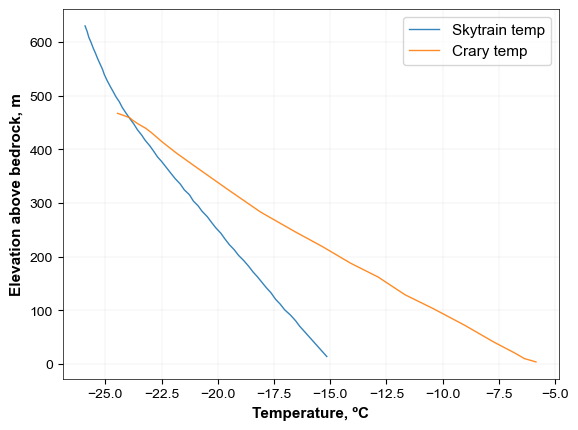

In [16]:
Bindschadler_Crary_T_profile_D = np.genfromtxt('Binschadler_Crary_D_Temps.txt', delimiter='\t', skip_header=1)
Skytrain_T_profile = np.genfromtxt('skytrain_temp_profile.csv', delimiter=',', skip_header=1)



##### Plotting the results

plt.plot(Skytrain_T_profile[:,0],Skytrain_T_profile[:,1], linewidth=1, alpha=0.9,  label='Skytrain temp')
plt.plot(Bindschadler_Crary_T_profile_D[:,0], Bindschadler_Crary_T_profile_D[:,1], linewidth=1, alpha=0.9,  label='Crary temp')
#plt.plot(Tm_ungrounded_regrounded_var_360_470_int["Tvar_H_Tmatrix"][:,-1],Tm_ungrounded_regrounded_var_360_470_int["zvar_H_Tmatrix"][:,-1], 'r', linewidth=2, alpha=0.15, label='Modelled temperature')
plt.ylabel('Elevation above bedrock, m')
plt.xlabel('Temperature, ºC')
plt.grid()
plt.legend()

In [33]:
def rsmpl_2(T_in, z_in, dz):
    flinear = interp1d(z_in, T_in)
    
    z_out = np.arange(round(min(z_in)+5.1, -1), int(max(z_in)), dz)
    T_out = flinear(z_out)
    
    return [T_out, z_out]

In [36]:
T_interp_skytrain = rsmpl_2(Skytrain_T_profile[:,0],Skytrain_T_profile[:,1], 10)
#print(T_interp_skytrain)

Tmeasured = T_interp_skytrain[0]
#print(Tmeasured)

[array([-15.28457566, -15.49789888, -15.71122211, -15.92454533,
       -16.13786856, -16.35366865, -16.53156579, -16.74451084,
       -17.00218635, -17.1978851 , -17.42054884, -17.5913616 ,
       -17.79725823, -17.99699211, -18.1916255 , -18.40207422,
       -18.59095453, -18.79272806, -19.02211533, -19.21851659,
       -19.43567366, -19.6292223 , -19.80413219, -20.00805492,
       -20.20832808, -20.38958476, -20.59719005, -20.79599029,
       -21.00398186, -21.18306919, -21.38050795, -21.58281388,
       -21.77737387, -21.9861009 , -22.17553316, -22.36273386,
       -22.55850437, -22.74980876, -22.91477454, -23.0965092 ,
       -23.28315968, -23.45428983, -23.62906595, -23.78634454,
       -23.95904944, -24.12440237, -24.27421372, -24.40360649,
       -24.55722078, -24.68780448, -24.81932479, -24.94316221,
       -25.05229586, -25.13787612, -25.24729695, -25.35304198,
       -25.45009861, -25.55313089, -25.64557245, -25.74421699,
       -25.81383326]), array([ 20.,  30.,  40.,  50., 